Reading /home/gweindel/owncloud/projects/RUGUU/man_hmp/V2/results/replication/P3_data/7_reref_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     796.88 ms
        0 CTF compensation matrices available
Adding metadata with 20 columns
192 matching events found
No baseline correction applied
0 projection items activated
Processing participant P3_data/7_reref_epo.fif's epoched eeg
192 trials were retained for participant P3_data/7_reref_epo.fif
Processing participant P3_data/26_reref_epo.fif's epoched eeg
198 trials were retained for participant P3_data/26_reref_epo.fif
Processing participant P3_data/34_reref_epo.fif's epoched eeg
182 trials were retained for participant P3_data/34_reref_epo.fif
Processing participant P3_data/16_reref_epo.fif's epoched eeg
194 trials were retained for participant P3_data/16_reref_epo.fif
Processing participant P3_data/8_reref_epo.fif's epoched eeg
146 trials were retained for participant P3_data/8_reref_epo.fif
Processing participan

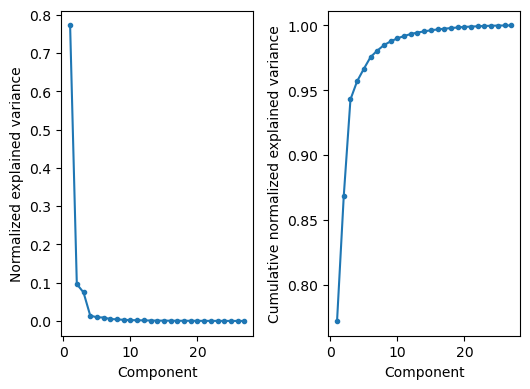

How many PCs (95 and 99% explained variance at component n4 and n10; components till n4 explain at least 1%)? 10


  0%|          | 0/107 [00:00<?, ?it/s]

Transition event 1 found around sample 22
Transition event 2 found around sample 49
Transition event 3 found around sample 98

All events found, refitting final combination.
Estimating 3 events model
parameters estimated for 3 events model


  0%|          | 0/120 [00:00<?, ?it/s]

Transition event 1 found around sample 21
Transition event 2 found around sample 52
Transition event 3 found around sample 98
Transition event 4 found around sample 114

All events found, refitting final combination.
Estimating 4 events model
parameters estimated for 4 events model


In [1]:
import os
import mne
import hmp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import bambi as bmb
import arviz as az


epoch_data_path = os.path.join('P3_data/')#Declaring path where the eeg data is
subj_names = [x.split('.')[0] for x in os.listdir(epoch_data_path) if 'reref_epo.fif' in x]#Extracting subject name based on the file name
subj_files = [epoch_data_path+x+'.fif' for x in subj_names]#Create a list of files that can be read from the folder

epochs = mne.read_epochs(subj_files[0])
epoch_data = hmp.utils.read_mne_data(subj_files,epoched=True, scale=1000,
                                     offset_after_resp=.05, upper_limit_RT=.75,
                                     verbose=False)


hmp_data = hmp.utils.transform_data(epoch_data)


hmp_data_frequent = hmp.utils.condition_selection(hmp_data, epoch_data, 'Frequent', variable='Trial type')
hmp_data_rare = hmp.utils.condition_selection(hmp_data, epoch_data, 'Rare', variable='Trial type')

init_frequent = hmp.models.hmp(hmp_data_frequent)
init_rare = hmp.models.hmp(hmp_data_rare)

fit_frequent = init_frequent.fit(tolerance=1e-6)
fit_rare = init_rare.fit(tolerance=1e-6)


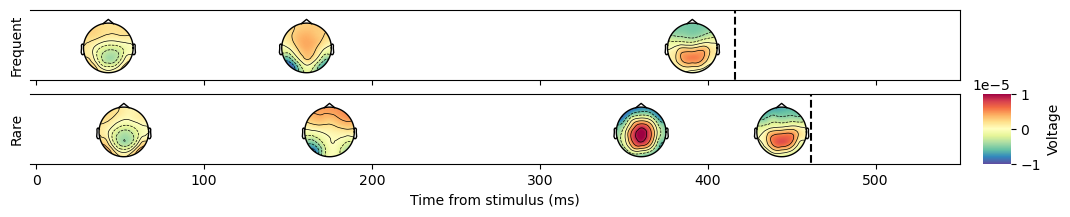

In [2]:
fig, ax = plt.subplots(2,1, figsize=(12,2), sharex=True)
ax_sp = hmp.visu.plot_topo_timecourse(epoch_data, fit_frequent, epochs.info, init_frequent, as_time=True, ax=ax[0], event_lines=None, 
                                      max_time=550, vmin=-1e-5, vmax=1e-5, colorbar=False)
ax[0].set_ylabel('Frequent')
ax_acc = hmp.visu.plot_topo_timecourse(epoch_data, fit_rare, epochs.info, init_rare, as_time=True, ax=ax[1], event_lines=None, 
                                       max_time=550, vmin=-1e-5, vmax=1e-5, colorbar=True)
ax[1].set_ylabel('Rare')
ax[1].set_xlabel('Time from stimulus (ms)')
fig.savefig('HMP_P3_solution.png',dpi=300,transparent=True,bbox_inches='tight')


In [3]:
# Exporting P3 topo for later comparison
init_rare.compute_topologies(epoch_data, fit_rare, init_rare, mean=True)[2].to_netcdf("P3_topo.nc")

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [4]:
epoch_data_wort = hmp.utils.read_mne_data(subj_files,epoched=True, scale=1,
                                     verbose=False, ignore_rt=True)


Processing participant P3_data/7_reref_epo.fif's epoched eeg
192 trials were retained for participant P3_data/7_reref_epo.fif
Processing participant P3_data/26_reref_epo.fif's epoched eeg
198 trials were retained for participant P3_data/26_reref_epo.fif
Processing participant P3_data/34_reref_epo.fif's epoched eeg
182 trials were retained for participant P3_data/34_reref_epo.fif
Processing participant P3_data/16_reref_epo.fif's epoched eeg
196 trials were retained for participant P3_data/16_reref_epo.fif
Processing participant P3_data/8_reref_epo.fif's epoched eeg
147 trials were retained for participant P3_data/8_reref_epo.fif
Processing participant P3_data/40_reref_epo.fif's epoched eeg
107 trials were retained for participant P3_data/40_reref_epo.fif
Processing participant P3_data/24_reref_epo.fif's epoched eeg
184 trials were retained for participant P3_data/24_reref_epo.fif
Processing participant P3_data/22_reref_epo.fif's epoched eeg
167 trials were retained for participant P3_da

In [5]:
init_rare.compute_topologies(epoch_data, fit_rare, init_rare).sel(event=2).idxmax()

<xarray.DataArray 'channels' ()> Size: 8B
array('Cz', dtype=object)
Coordinates:
    event    int64 8B 2

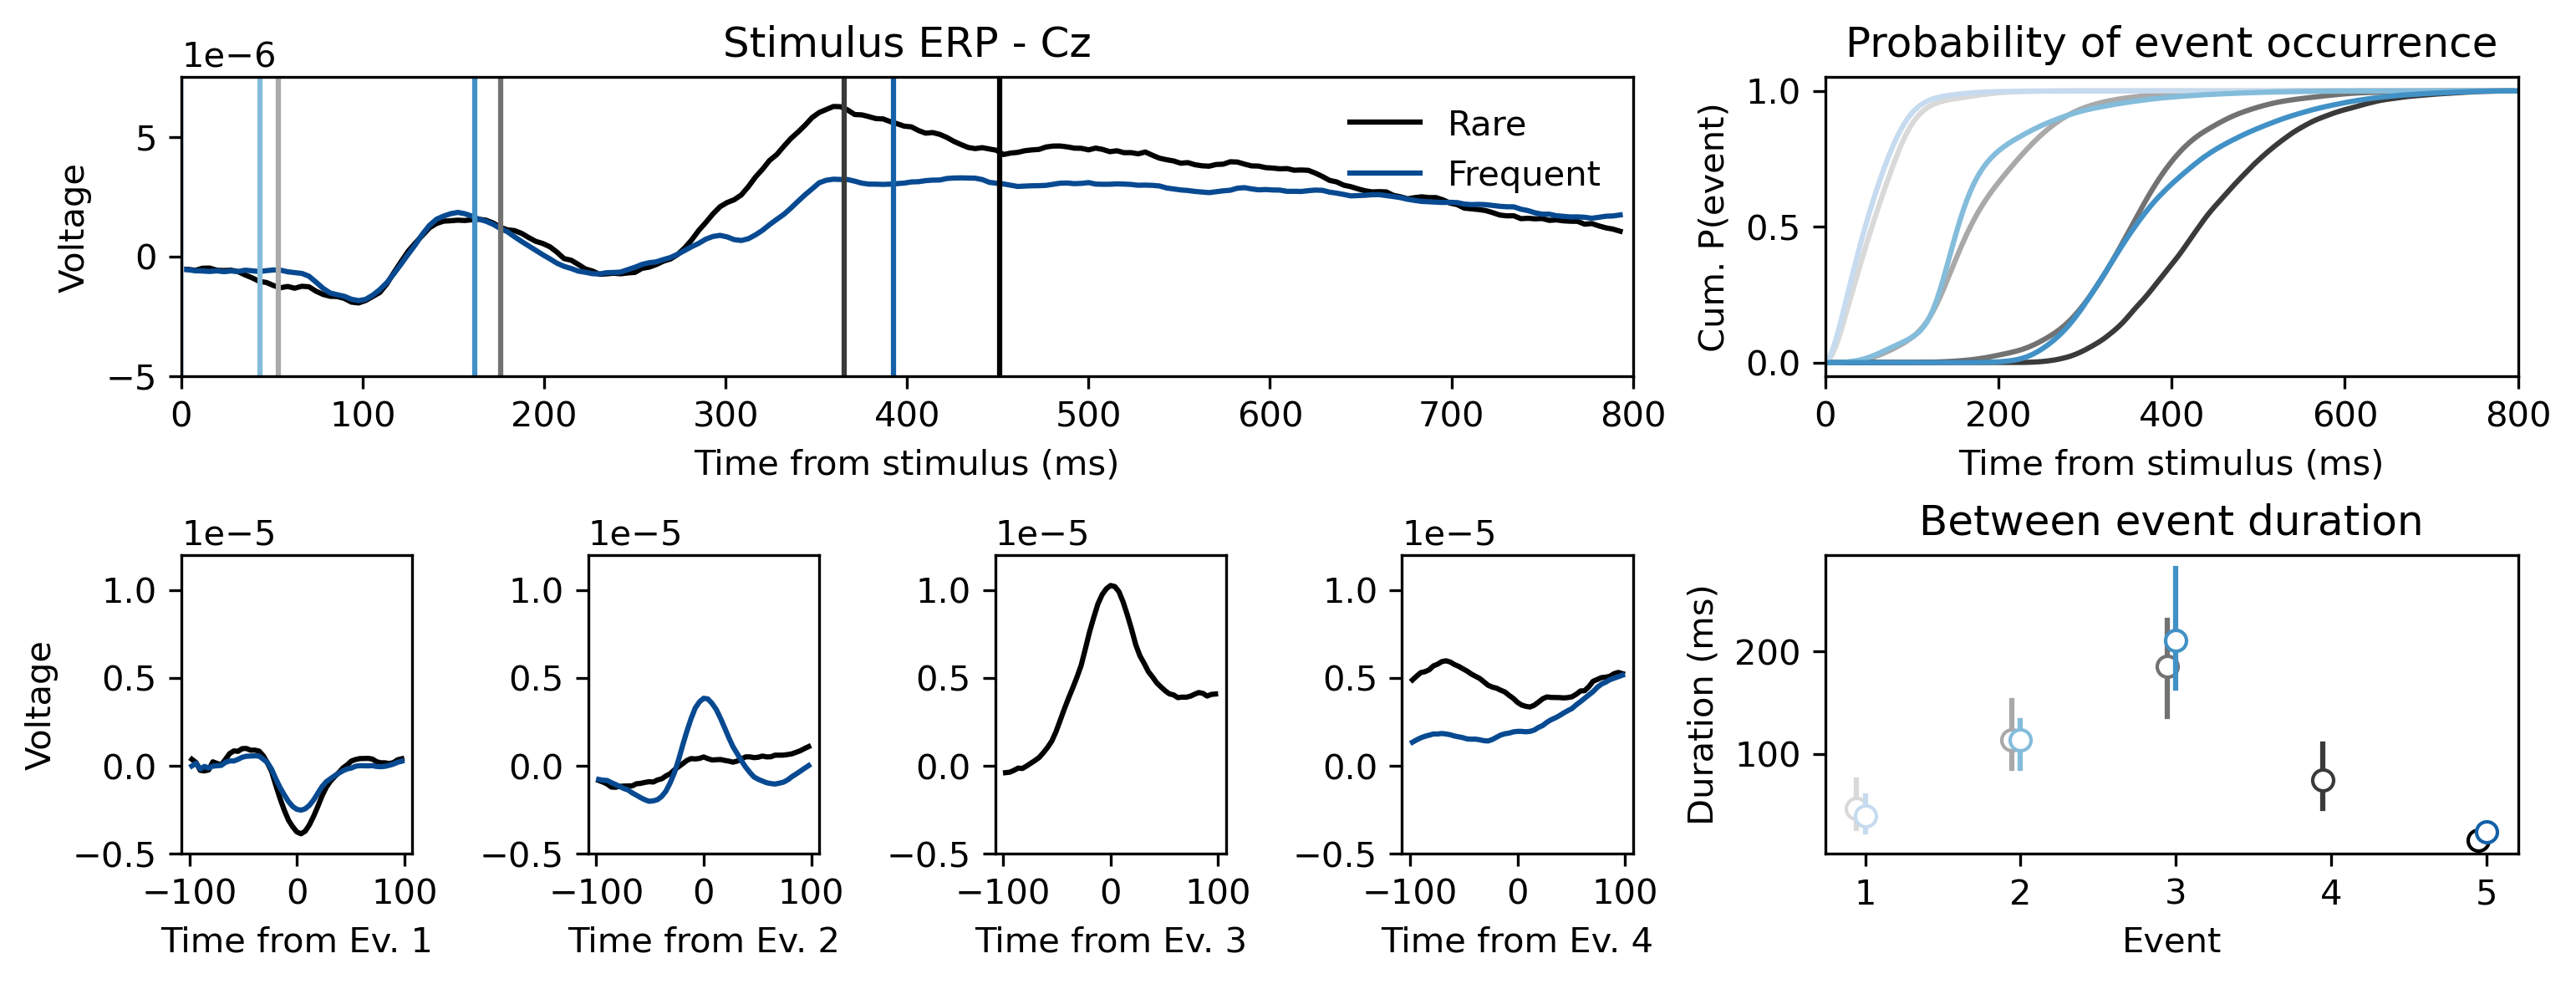

In [7]:
color_cond = {'Frequent':plt.cm.Blues(.9),'Rare':plt.cm.Greys(.99)}
fig = plt.figure(constrained_layout=True, figsize=(12, 5), dpi=300)
gs = fig.add_gridspec(3, 6, width_ratios=[1, 1, 1, 1, 3, 2])
tstep = 1000/epochs.info['sfreq']

probs_mean_rare = fit_rare.eventprobs.mean('trial_x_participant')
probs_mean_frequent = fit_frequent.eventprobs.mean('trial_x_participant')

color_ev_frequent = {i: plt.cm.Blues(x) for i,x in enumerate(np.linspace(.25,1, probs_mean_rare.shape[-1]+1))}
color_ev_rare = {i: plt.cm.Greys(x) for i,x in enumerate(np.linspace(.25,1, probs_mean_rare.shape[-1]+1))}
color_cond_ev = {'Frequent':color_ev_frequent,'Rare':color_ev_rare}

times_frequent = init_frequent.compute_times(init_frequent, fit_frequent, fill_value=0, add_rt=True)
times_rare = init_rare.compute_times(init_rare, fit_rare, fill_value=0, add_rt=True)
data = epoch_data_wort.stack({'trial_x_participant':['participant','epochs']}).data.dropna('trial_x_participant', how="all")
mean_times_rare = times_rare.mean('trial_x_participant')
mean_times_frequent = times_frequent.mean('trial_x_participant')

ax1 = fig.add_subplot(gs[0, :4])

# Plotting the single trial aligned events
baseline, n_samples = -25, 25
for i, event in enumerate(times_rare.event[1:-1]):
    ax = fig.add_subplot(gs[1, i])
    centered = hmp.utils.centered_activity(data, times_rare, ["Cz"], event=event, baseline=baseline, n_samples=n_samples)
    ax.plot(centered.samples*tstep, centered.data.unstack().mean(['trials', 'channel', 'participant']).data, color=color_cond['Rare'])
    if event < 3:
        centered = hmp.utils.centered_activity(data, times_frequent, ["Cz"], event=event, baseline=baseline, n_samples=n_samples)
        ax.plot(centered.samples*tstep, centered.data.unstack().mean(['trials', 'channel', 'participant']).data, color=color_cond['Frequent'])
    elif event == 4:
        centered = hmp.utils.centered_activity(data, times_frequent, ["Cz"], event=event-1, baseline=baseline, n_samples=n_samples)
        ax.plot(centered.samples*tstep, centered.data.unstack().mean(['trials', 'channel', 'participant']).data, color=color_cond['Frequent'])
        
    ax.set_ylim(-.5e-5,1.2e-5)
    ax.set_xlabel(f'Time from Ev. {event.values}')
    if i == 0:
        ax.set_ylabel("Voltage")

centered = hmp.utils.centered_activity(data, times_rare, ["Cz"], event=0, n_samples=256, baseline=0).data.unstack().mean(['trials', 'channel', 'participant'])
ax1.plot(centered.samples*tstep, centered.data, color=color_cond['Rare'], label='Rare')
centered = hmp.utils.centered_activity(data, times_frequent, ["Cz"], event=0, n_samples=256, baseline=0).data.unstack().mean(['trials', 'channel', 'participant'])
ax1.plot(centered.samples*tstep, centered.data, color=color_cond['Frequent'], label='Frequent')
ax1.set_ylim(-.5e-5, .75e-5)
ax1.set_xlim(0, 800)
ax1.set_xlabel('Time from stimulus (ms)')
ax1.set_ylabel('Voltage')
ax1.set_title('Stimulus ERP - Cz')
ax1.legend(loc="upper right", frameon=False)

durations_rare = init_rare.compute_times(init_rare, fit_rare, duration=True, mean=False, add_rt=True).T
times_rare = init_rare.compute_times(init_rare, fit_rare, duration=False, mean=False, add_rt=True).T
durations_frequent = init_frequent.compute_times(init_frequent, fit_frequent, duration=True, mean=False, add_rt=True).T
times_frequent = init_frequent.compute_times(init_frequent, fit_frequent, duration=False, mean=False, add_rt=True).T
estim_n_events = len(times_rare.event[:-1])

for i in range(estim_n_events + 1):
    ax1.vlines(mean_times_rare[i]*tstep, -1, 1, color=color_cond_ev['Rare'][i])
for i in range(estim_n_events):
    ax1.vlines(mean_times_frequent[i]*tstep, -1, 1, color=color_cond_ev['Frequent'][i])

ax2_0 = fig.add_subplot(gs[0, 4])
for i in range(estim_n_events):
    ax2_0.plot(probs_mean_rare[:, i].samples*tstep, np.cumsum(probs_mean_rare[:, i]), color=color_cond_ev['Rare'][i])
for i in range(estim_n_events-1):
    ax2_0.plot(probs_mean_frequent[:, i].samples*tstep, np.cumsum(probs_mean_frequent[:, i]), color=color_cond_ev['Frequent'][i])
ax2_0.set_ylabel('Cum. P(event)')
ax2_0.set_xlabel('Time from stimulus (ms)')
ax2_0.set_xlim(0, 800)
ax2_0.set_title('Probability of event occurrence')


ax2_1 = fig.add_subplot(gs[1, 4])
for i in range(estim_n_events + 1):
    ax2_1.plot(np.repeat(i + 1, 2) - .055, np.percentile(durations_rare[i, :].T, q=[25, 75])*tstep, color=color_cond_ev['Rare'][i])
    ax2_1.plot(i + 1 - .055, np.percentile(durations_rare[i, :].T, q=[50])*tstep, 'o', markerfacecolor='w', markeredgecolor=color_cond_ev['Rare'][i])
for i in range(estim_n_events):
    if i == 3:
        i_ev = 4
    else: i_ev = i
    ax2_1.plot(np.repeat(i_ev + 1, 2), np.percentile(durations_frequent[i, :].T, q=[25, 75])*tstep, color=color_cond_ev['Frequent'][i])
    ax2_1.plot(i_ev + 1, np.percentile(durations_frequent[i, :].T, q=[50])*tstep, 'o', markerfacecolor='w', markeredgecolor=color_cond_ev['Frequent'][i])

ax2_1.set_xlabel('Event')
ax2_1.set_ylabel('Duration (ms)')
ax2_1.set_title('Between event duration')
plt.savefig('HMP_plot_P3.png',dpi=300,transparent=True,bbox_inches='tight')
plt.show()

In [8]:
times_rare.sel(event=2).mean()*(1000/256)

<xarray.DataArray 'eventprobs' ()> Size: 8B
array(365.18603032)
Coordinates:
    event      int64 8B 2
    component  int64 8B 0

In [9]:
times_rare.sel(event=2).std()*(1000/256)

<xarray.DataArray 'eventprobs' ()> Size: 8B
array(76.77145313)
Coordinates:
    event      int64 8B 2
    component  int64 8B 0